## First data analysis
This notebook performs a first set of analysis using the previously generated datasets.

The two data sources are:
- our own **movie dataset** extracted in `movieProcessing`.
- our own **quote datasets** extracted in `mergeDataSets`.

The initial architecture to run this notebook should be the following:
```
    .
    ├── analysis
    │   └── analysisQuote.ipynb       # this notebook 
    │
    └── data/                         # the datasets we need
        │   # from the `moviePreprocessing` notebook
        ├── movie_data_2015_2020.csv
        │
        │   # from the `mergeDataSets` notebook
        ├── movie_2015_crew_quotes.csv.gz
        ├── movie_2016_crew_quotes.csv.gz
        ├── movie_2017_crew_quotes.csv.gz
        ├── movie_2018_crew_quotes.csv.gz
        ├── movie_2019_crew_quotes.csv.gz
        └── movie_2020_crew_quotes.csv.gz
```
where each quotes files is created in the `mergeDataSets` notebook, and movie_data_2015_2020.csv is created in the `moviePreprocessing` notebook.

We run various analysis on these datasets to try and find any initial interesting correlations or other result between quotes and boxoffices results, in order to motivate the project.

**The goal of this notebook is to generate artifacts that can be used in the milestone 2 report, and find correlations or other useful information. The artifacts will be located in the `assets` folder.**

In [1]:
# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sc

# Constants to easily update and read the code
DATA_DIR = "../data/"
ASSETS_DIR = "../assets/"
MOVIE_DATASET = "movie_data_2015_2020.csv"
START_YEAR = 2015
END_YEAR = 2020
YEARS = range(START_YEAR, END_YEAR + 1)

# Auxiliary functions
def quotes_dataset(year):
    return f"movie_{year}_crew_quotes.csv.gz"

## 1. Open datasets
#### Datasets of quotes whose speaker is part of a 2015-2020 movie crew (actor, director, etc)

In [2]:
# Read and concatenate the quotes from the datasets
# generated in `mergeDataSets`
quotes = pd.DataFrame()
for year in YEARS:
    quotes = pd.concat((quotes, pd.read_csv(DATA_DIR + quotes_dataset(year))))

#### Movie and box office information dataset

In [3]:
# Read the movie dataset
# (created in `moviePreprocessing`)
movies = pd.read_csv(DATA_DIR + MOVIE_DATASET)

# Map "Total Gross" column to a numeral value
movies["Total Gross"] = pd.to_numeric(movies["Total Gross"].apply(lambda x: x[1:].replace(",", "")))

## 2. Filter unused rows

In [4]:
# Keep relevant years only
# (we want quotes up to a year before and after the movie release date
# so we also filter the movies released in 2015 and 2020)
movies = movies[(movies["Year"] > START_YEAR) & (movies["Year"] < END_YEAR)]

# Sort by total gross
movies = movies.sort_values(["Total Gross"], ascending=False)

movies.head()

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,...,ordering_y,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
1704,1704,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0.0,2019.0,NaN,181.0,"Action,Adventure,Drama",...,8.0,nm1321656,writer,screenplay by,NaN,Stephen McFeely,NaN,NaN,"writer,producer,actor","tt4154796,tt0458339,tt3498820,tt4154756"
1671,1671,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0.0,2019.0,NaN,181.0,"Action,Adventure,Drama",...,2.0,nm0262635,actor,NaN,"[""Steve Rogers"",""Captain America""]",Chris Evans,1981.0,NaN,"actor,producer,soundtrack","tt3498820,tt0458339,tt1843866,tt0848228"
1701,1701,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0.0,2019.0,NaN,181.0,"Action,Adventure,Drama",...,7.0,nm1321655,writer,screenplay by,NaN,Christopher Markus,1970.0,NaN,"writer,producer,actor","tt4154796,tt3498820,tt0458339,tt4154756"
1698,1698,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0.0,2019.0,NaN,181.0,"Action,Adventure,Drama",...,6.0,nm0751648,director,NaN,NaN,Joe Russo,1971.0,NaN,"producer,director,writer","tt3498820,tt4154796,tt4154756,tt1843866"
1503,1503,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0.0,2019.0,NaN,181.0,"Action,Adventure,Drama",...,9.0,nm0498278,writer,based on the Marvel comics by,NaN,Stan Lee,1922.0,2018.0,"producer,writer,actor","tt1211837,tt2250912,tt1825683,tt3896198"


## 3. Merge data sets

In [5]:
# Merge the movies with their associated quotes.
data = pd.merge(quotes, movies, how="inner", left_on="speaker", right_on="primaryName")

## 4. Compute and store number of days to release for each quote

In [6]:
# Map column to a date format
# and add some date related columns

# Add the year in the release date
data["Release Date"] = data["Release Date"] + ", " + data["Year"].astype(int).astype(str)

# Map "Release Date" and "date" to a date format
data["Release Date"] = pd.to_datetime(data["Release Date"])
data["date"] = data["date"].values.astype('datetime64[D]')

# Create the date_diff column which contains the time between
# the release date and the date of the quote
data["date_diff"] = (data["Release Date"] - data["date"]).dt.days

data.head()

,Unnamed: 0_x,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,date_diff
0,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,nm0000949,actress,NaN,"[""Hela""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",954
1,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,nm0000949,actress,NaN,"[""Valka""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",1430
2,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,nm0000949,actress,NaN,"[""Lou""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",1171
3,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,nm0000949,actress,NaN,"[""Florence Zimmerman""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",1276
4,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,nm0000949,actress,NaN,"[""Bernadette""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",1605


## 5. Aggregation: count per movie per title and date to the release

In [7]:
# Compute the number of quotes for a given movie and a given time to the release date
nbquotes_by_title_time = data.groupby(["primaryTitle", "date_diff"], as_index=False)
nbquotes_by_title_time = nbquotes_by_title_time.agg({
    'primaryTitle': 'first',
    'date_diff': 'first',
    'Year': 'first',
    'numOccurrences': 'count'
})

nbquotes_by_title_time.head()

,primaryTitle,date_diff,Year,numOccurrences
0,10 Cloverfield Lane,-1497,2016.0,1
1,10 Cloverfield Lane,-1490,2016.0,3
2,10 Cloverfield Lane,-1488,2016.0,1
3,10 Cloverfield Lane,-1483,2016.0,3
4,10 Cloverfield Lane,-1482,2016.0,1


## 6. Press activity around release date

In [8]:
# Compute the number of quotes depending on the time to the release date
# (aggregating movies)
nbquotes_by_time = nbquotes_by_title_time.groupby(["date_diff"]).sum()[["numOccurrences"]]
nbquotes_by_time = nbquotes_by_time.reset_index()

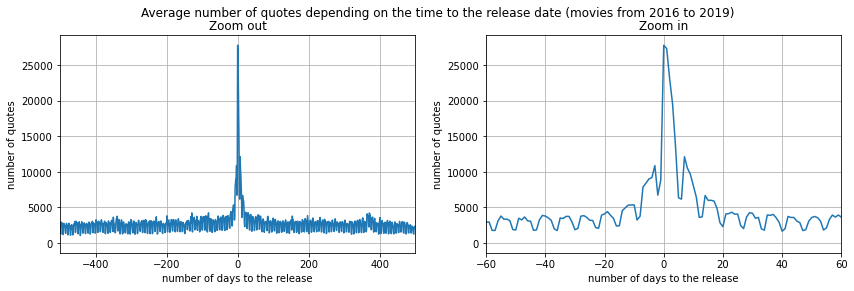

In [9]:
# Display the number of quotes depending on
# the number of days to the release date

ZOOM_OUT_DELTA = 500
ZOOM_IN_DELTA = 60
XLABEL = "number of days to the release"
YLABEL = "number of quotes"

plt.figure(figsize=(14,4))
plt.suptitle(f"Average number of quotes depending on the time to the release date (movies from {START_YEAR+1} to {END_YEAR-1})")

# Plots
def plot_zoom(title, delta, total, pos):
    plt.subplot(1, total, pos)
    sb.lineplot(x="date_diff", y="numOccurrences", data=nbquotes_by_time)
    plt.xlabel(XLABEL)
    plt.ylabel(YLABEL)
    plt.grid()
    plt.xlim(-delta, delta)
    plt.title(title)

# Firstly, a "zoomed out" view, from -500 to +500 days
plot_zoom("Zoom out", ZOOM_OUT_DELTA, 2, 1)

# Secondly, a "zoomed in" view, from -60 to +60 days
plot_zoom("Zoom in", ZOOM_IN_DELTA, 2, 2)

# Save both plots to display them in the README
plt.savefig(ASSETS_DIR + "quotes_around_release.png")

We can observe a few interesting things from these plots:
- there is a burst of quotes on the release date, and a few days after
- there are more quotes the weeks before and after the release date than the rest of the year (it kind of looks like a normal curve)
- there seems to be a *small* spike one year after the release date
- the number of quotes might be related to the day of the week, since we notice a sinusoidal pattern of around 7 days 
- there are always around 2500 quotes per day, even a long time before or after the release date, indicating a possibly large amount quotes that are not actually related to the movie, which seems normal since we didn't filter the quotes using their textual content
- the mediatic life of a movie seems very short

These observation will help us improve our future analysis at all steps, from cleaning the possibly large number of unrelated quotes to analysing the quote frequency and its evolution depending on specific date factors (day of the week, specific time after the release date, etc).

## 7. Correlation Box office - quotes counts

In [10]:
# Compute the number of quotes depending on the year,
# the movie and the time to the release

DATE_DIFF_THRESHOLD = 4 # one week around the release date
COUNT_THRESHOLD = 10

# Filter out quotes outside of one week around the release date
nbquotes_by_title = data[data["date_diff"].abs() < DATE_DIFF_THRESHOLD]
nbquotes_by_title = nbquotes_by_title.groupby(["primaryTitle"],as_index=False)
nbquotes_by_title = nbquotes_by_title.agg({
    'primaryTitle': 'first',
    'Total Gross': 'first',
    'Year': 'first',
    'numOccurrences': 'count'
})

# Filter out movies without at least 10 quotes
nbquotes_by_title = nbquotes_by_title[nbquotes_by_title["numOccurrences"] > COUNT_THRESHOLD]

nbquotes_by_title.head()

,primaryTitle,Total Gross,Year,numOccurrences
1,12 Strong,45819713,2018.0,259
3,2.0,4152000,2018.0,117
4,20th Century Women,5664764,2017.0,48
5,21 Bridges,28539757,2019.0,177
7,47 Meters Down,44307191,2017.0,167


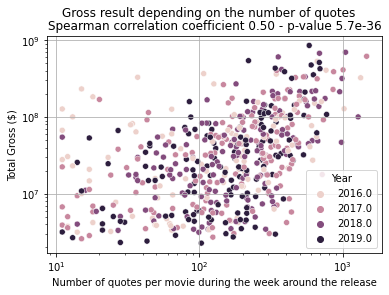

In [11]:
# Compute the Spearman correlation of the number of quotes depending
# on the boxoffice results (across years)
a = sc.stats.spearmanr(nbquotes_by_title["numOccurrences"], nbquotes_by_title["Total Gross"])

# Plot the total gross depending on the number of quotes
# during the week around the release date
# with a different color per year
sb.scatterplot(x="numOccurrences", y="Total Gross", data=nbquotes_by_title, hue="Year")
plt.xlabel("Number of quotes per movie during the week around the release")
plt.ylabel("Total Gross ($)")
plt.xscale("log")
plt.yscale("log")

plt.title(f"Spearman correlation coefficient {a[0]:.2f} - p-value {a[1]:.1e}")
plt.suptitle("Gross result depending on the number of quotes")
plt.grid()

# Save the plot to display it in the README
plt.savefig(ASSETS_DIR + "gross_vs_occurrences.png")

A visual inspection of the data suggests the existence of a correlation between the number of quotes and the box office results of the movie.

The Pearsman correlation coefficient (0.5) and the associated p-value (5.7e-36) seem to confirm that there is such correlation.